In [7]:
import json
with open("../data/raw/polymarket_20251109_2000.json") as f:
    data = json.load(f)

print(type(data))
print(data.keys())


<class 'dict'>
dict_keys(['data', 'next_cursor', 'limit', 'count'])


In [8]:
markets = data["data"]
print(len(markets))
print(markets[0].keys())
print(markets[0]["question"])
print(markets[0]["tokens"])


1000
dict_keys(['enable_order_book', 'active', 'closed', 'archived', 'accepting_orders', 'accepting_order_timestamp', 'minimum_order_size', 'minimum_tick_size', 'condition_id', 'question_id', 'question', 'description', 'market_slug', 'end_date_iso', 'game_start_time', 'seconds_delay', 'fpmm', 'maker_base_fee', 'taker_base_fee', 'notifications_enabled', 'neg_risk', 'neg_risk_market_id', 'neg_risk_request_id', 'icon', 'image', 'rewards', 'is_50_50_outcome', 'tokens', 'tags'])
NCAAB: Arizona State Sun Devils vs. Nevada Wolf Pack 2023-03-15
[{'token_id': '73470541315377973562501025254719659796416871135081220986683321361000395461644', 'outcome': 'Arizona State', 'price': 1, 'winner': True}, {'token_id': '56393761733830483601097051857899348522495376869600726893014309766300892311293', 'outcome': 'Nevada', 'price': 0, 'winner': False}]


In [10]:
m = markets[0]
print(m["question"])
print(m["tokens"])

NCAAB: Arizona State Sun Devils vs. Nevada Wolf Pack 2023-03-15
[{'token_id': '73470541315377973562501025254719659796416871135081220986683321361000395461644', 'outcome': 'Arizona State', 'price': 1, 'winner': True}, {'token_id': '56393761733830483601097051857899348522495376869600726893014309766300892311293', 'outcome': 'Nevada', 'price': 0, 'winner': False}]


In [19]:
import pandas as pd

records = []
for m in markets:
    q = m["question"]
    # iterate over the list of token dicts (not the literal string "tokens")
    for t in m.get("tokens", []):
        records.append({
            "question": q,
            "outcome": t.get("outcome"),
            "price": t.get("price"),
            "winner": t.get("winner", None),
            "closed": m.get("closed", None)
        })

df = pd.DataFrame(records)
print(df.head())


                                            question        outcome  price  \
0  NCAAB: Arizona State Sun Devils vs. Nevada Wol...  Arizona State    1.0   
1  NCAAB: Arizona State Sun Devils vs. Nevada Wol...         Nevada    0.0   
2  NCAAB: Tennessee Volunteers vs. Duke Blue Devi...      Tennessee    1.0   
3  NCAAB: Tennessee Volunteers vs. Duke Blue Devi...           Duke    0.0   
4      NBA: LA Clippers vs. Orlando Magic 2023-03-18       Clippers    0.0   

   winner  closed  
0    True    True  
1   False    True  
2    True    True  
3   False    True  
4   False    True  


In [21]:
df.info
df['closed'].value_counts(dropna=False)

closed
True     1882
False     118
Name: count, dtype: int64

In [53]:
df_active = df[df["closed"] == False]

print(df_active)


                                               question outcome  price  \
30    Will Newcastle beat Nottingham Forest? (03/17/...            0.0   
31    Will Newcastle beat Nottingham Forest? (03/17/...            0.0   
50    Will a mugshot of Donald Trump be released by ...            0.0   
51    Will a mugshot of Donald Trump be released by ...            0.0   
86    archWill Gavin Newsom win the 2024 US Presiden...     Yes    0.5   
...                                                 ...     ...    ...   
1921  Will Coinbase staking be available in the US t...            0.0   
1954  archWill Joe Biden win the 2024 US Presidentia...            0.0   
1955  archWill Joe Biden win the 2024 US Presidentia...            0.0   
1992  archWill Kamala Harris win the 2024 US Preside...            0.0   
1993  archWill Kamala Harris win the 2024 US Preside...            0.0   

      winner  closed  
30     False   False  
31     False   False  
50     False   False  
51     False   Fals

In [55]:
df_active = df[(df["closed"] == False) | (df["closed"].isna())]

price_sums = (
    df_active.groupby("question")["price"]
    .sum()
    .reset_index(name="price_sum")
)

overpriced  = price_sums[price_sums["price_sum"] > 1]
underpriced = price_sums[price_sums["price_sum"] < 1]
print("Overpriced markets:")
print(overpriced.head())

print("\nUnderpriced markets:")
print(underpriced.head())

price_sums.sort_values("price_sum").head(10)  # most underpriced
price_sums.sort_values("price_sum", ascending=False).head(10)  # most overpriced


Overpriced markets:
Empty DataFrame
Columns: [question, price_sum]
Index: []

Underpriced markets:
                                            question  price_sum
0                       WILL $BUSD depeg by April 1?        0.0
1  Which party will control the U.S. Senate after...        0.0
2        Who will win Super Bowl LVII? (no overtime)        0.0
3  Will "Flowers" be #1 globally on Spotify for J...        0.0
4       Will "PredictIt Exchange" be live by June 1?        0.0


,question,price_sum
5,Will $BTC reach $1700 by January 4?,1.0
47,archWill Joe Biden win the 2024 US Presidentia...,1.0
46,archWill Gavin Newsom win the 2024 US Presiden...,1.0
45,archWill Donald Trump win the 2024 US Presiden...,1.0
0,WILL $BUSD depeg by April 1?,0.0
41,Will the clob strapi integration work?,0.0
31,Will a mugshot of Donald Trump be released by ...,0.0
32,Will a third US bank fail by March 31?,0.0
33,Will any field goal be scored from 55 yards or...,0.0
34,Will more than 35 Million USDC be in circulati...,0.0


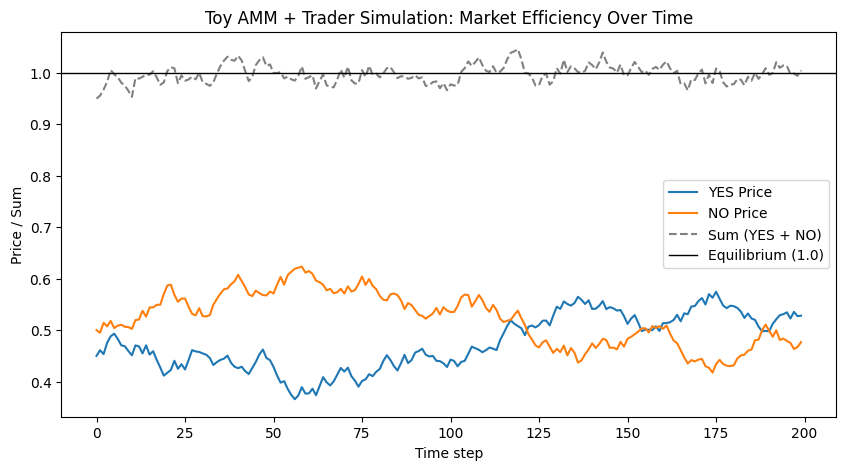

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
n_steps = 200
p_yes, p_no = 0.45, 0.50  # starts off-balance (sum = 0.95)
k_arbitrage = 0.3         # how strongly arbitrageurs react to imbalance
k_noise = 0.02            # how big random trader movements are

history = []

for t in range(n_steps):
    # Record state
    history.append((t, p_yes, p_no, p_yes + p_no))

    # --- Random traders move prices slightly ---
    noise = np.random.uniform(-k_noise, k_noise, size=2)
    p_yes += noise[0]
    p_no += noise[1]

    # --- Arbitrage pressure: if sum ≠ 1, correct it ---
    imbalance = (p_yes + p_no) - 1
    p_yes -= k_arbitrage * imbalance / 2
    p_no  -= k_arbitrage * imbalance / 2

    # --- Bound prices between 0 and 1 ---
    p_yes = np.clip(p_yes, 0, 1)
    p_no  = np.clip(p_no, 0, 1)

# Convert to array for plotting
history = np.array(history)
t, yes, no, total = history.T

# --- Plot ---
plt.figure(figsize=(10,5))
plt.plot(t, yes, label='YES Price')
plt.plot(t, no, label='NO Price')
plt.plot(t, total, '--', color='gray', label='Sum (YES + NO)')
plt.axhline(1.0, color='black', lw=1, label='Equilibrium (1.0)')
plt.legend()
plt.title("Toy AMM + Trader Simulation: Market Efficiency Over Time")
plt.xlabel("Time step")
plt.ylabel("Price / Sum")
plt.show()


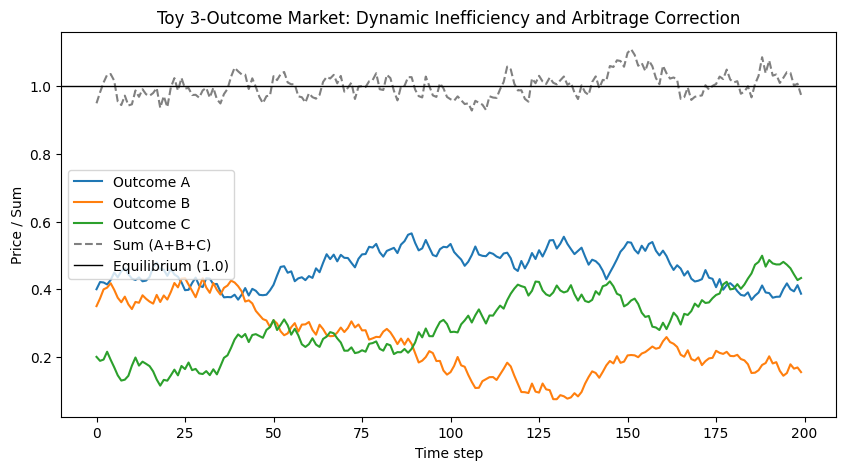

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
n_steps = 200
p_a, p_b, p_c = 0.4, 0.35, 0.20  # starts unbalanced (sum = 0.95)
k_arbitrage = 0.2                # weaker efficiency than before
k_noise = 0.03                   # random trader volatility

history = []

for t in range(n_steps):
    # Record current state
    history.append((t, p_a, p_b, p_c, p_a + p_b + p_c))

    # --- Random noise trading ---
    noise = np.random.uniform(-k_noise, k_noise, size=3)
    p_a += noise[0]
    p_b += noise[1]
    p_c += noise[2]

    # --- Arbitrage correction ---
    total = p_a + p_b + p_c
    imbalance = total - 1.0
    # Adjust all outcomes equally toward restoring sum=1
    p_a -= k_arbitrage * imbalance / 3
    p_b -= k_arbitrage * imbalance / 3
    p_c -= k_arbitrage * imbalance / 3

    # --- Keep probabilities valid ---
    p_a = np.clip(p_a, 0, 1)
    p_b = np.clip(p_b, 0, 1)
    p_c = np.clip(p_c, 0, 1)

# Convert to array for plotting
history = np.array(history)
t, a, b, c, total = history.T

# --- Plot ---
plt.figure(figsize=(10,5))
plt.plot(t, a, label='Outcome A')
plt.plot(t, b, label='Outcome B')
plt.plot(t, c, label='Outcome C')
plt.plot(t, total, '--', color='gray', label='Sum (A+B+C)')
plt.axhline(1.0, color='black', lw=1, label='Equilibrium (1.0)')
plt.legend()
plt.title("Toy 3-Outcome Market: Dynamic Inefficiency and Arbitrage Correction")
plt.xlabel("Time step")
plt.ylabel("Price / Sum")
plt.show()
